In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from collections import Counter

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import matthews_corrcoef, make_scorer, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
import xgboost as xg
from catboost import CatBoostClassifier
warnings.filterwarnings("ignore")
np.set_printoptions(precision=3)
pd.set_option('precision', 3)
from sklearn.neighbors import KNeighborsClassifier 

# check version number
from imblearn.over_sampling import SMOTE
# print(imblearn.__version__)

## загружаем данные 

In [2]:
data = pd.read_csv('train.csv', index_col=0)
data.head(5)


,Gender,Senior,Married,Dependents,Tenure,Phone,MultiplePhones,Internet,Security,Backup,Insurance,Support,TV,Movies,Contract,EBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
Index,,,,,,,,,,,,,,,,,,,,
0,Female,0,Yes,Yes,67,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),54.20,3623.95,False
1,Female,0,No,No,34,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,One year,Yes,Mailed check,64.40,2088.75,True
2,Female,1,Yes,No,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,No,No,Two year,Yes,Bank transfer (automatic),96.60,6827.5,False
3,Female,0,Yes,Yes,63,Yes,No,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,Mailed check,63.55,4014.2,False
4,Male,0,Yes,Yes,69,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,No,One year,No,Credit card (automatic),95.75,6511.25,False


## это думали вручную создать колонку признаков из других

In [18]:
# data['pers'] = 1.0
# data['pers2'] = 1.0
# data['pers']=data['pers'].astype(float)
ds = data.values
print(ds.shape)
for i in range(ds.shape[0]):
    sum = 1
    sum2 = 1
    if data['Internet'][i]==2 or data['Internet'][i]==1:
        sum*=1.2
    else:
        sum2*=1.2
    if data['Security'][i]==2:
         sum*=1.2
    else:
        sum2*=1.1
    if data['Backup'][i]==2:
         sum*=1.2
    else:
        sum2*=1.1
    if data['TV'][i]==2:
        sum*=1.2
    else:
        sum2*=1.1
    if data['Movies'][i]==2:
        sum*=1.2
    else:
        sum2*=1.1
    if data['Insurance'][i]==2:
         sum*=1.2
    else:
        sum2*=1.1
    if data['EBilling'][i]==0:
         sum*=1.2
    else:
        sum2*=1.05
    if data['Support'][i]==1:
         sum*=1.1
    else:
        sum2*=1.1
    if data['Senior'][i]==0:
        sum*=1.05
    else:
        sum2*=1.05
    if data['Contract'][i]==1 or data['Contract'][i]==0 or data['Contract'][i]==2:
         sum*=1.8
    else:
        sum2*=1.3
#     data['pers'][i] = sum
#     data['pers2'][i] = sum2
#     sum*=2.5
    data['MonthlyCharges'][i] = np.power(data['MonthlyCharges'][i],(sum/sum2))
    data['TotalCharges'][i] = np.power(data['TotalCharges'][i],(sum/sum2))
    data['MonthlyCharges'][i] /=data['Tenure'][i]
    data['TotalCharges'][i] /=data['Tenure'][i]

(3591, 20)


## нормальная замена на числа

In [3]:
data.TotalCharges = data.TotalCharges.replace(' ', 0).astype(float)
data = data.replace({'Gender': {'Female': 1, 'Male': 0}, 
                     'Married': {'Yes': 1, 'No': 0}, 
                     'Phone': {'Yes': 1, 'No': 0},
                     'Dependents': {'Yes': 1, 'No': 0},
                     'EBilling': {'Yes': 1, 'No': 0},
                     'MultiplePhones': {'Yes': 1, 'No': 0, 'No phone service':2},
                     'Internet' : {'DSL':1, 'Fiber optic':0,'No':2},
                     'Security' : {'Yes': 1, 'No': 0,'No internet service':2},
                     'Backup': {'Yes': 1, 'No': 0,'No internet service':2},
                     'Insurance' : {'Yes': 1, 'No': 0,'No internet service':2},
                     'Support' : {'Yes': 1, 'No': 0,'No internet service':2},
                     'TV' : {'Yes': 1, 'No': 0,'No internet service':2},
                     'Movies' : {'Yes': 1, 'No': 0,'No internet service':2},
                     'Contract' : {'Month-to-month': 2, 'One year': 1,'Two year':0},
                     'PaymentMethod' : {'Electronic check': 3, 'Mailed check': 2,'Bank transfer (automatic)':0,'Credit card (automatic)':1}
                    })
numeric_data = data.select_dtypes(include=np.number)
numeric_data.head(4)

,Gender,Senior,Married,Dependents,Tenure,Phone,MultiplePhones,Internet,Security,Backup,Insurance,Support,TV,Movies,Contract,EBilling,PaymentMethod,MonthlyCharges,TotalCharges
Index,,,,,,,,,,,,,,,,,,,
0,1,0,1,1,67,0,2,1,1,1,1,1,1,0,0,0,1,54.20,3623.95
1,1,0,0,0,34,1,1,1,1,1,0,1,0,0,1,1,2,64.40,2088.75
2,1,1,1,0,72,1,1,0,1,1,1,1,0,0,0,1,0,96.60,6827.50
3,1,0,1,1,63,1,0,1,1,1,1,1,0,0,0,0,2,63.55,4014.20


## думали заменить таким образом, чтобы возможно повысить корреляцию

In [49]:
data.TotalCharges = data.TotalCharges.replace(' ', 0).astype(float)
data = data.replace({'Gender': {'Female': 1, 'Male': 0}, 
                     'Married': {'Yes': 1, 'No': 0}, 
                     'Phone': {'Yes': 1, 'No': 0},
                     'Dependents': {'Yes': 1, 'No': 0},
                     'EBilling': {'Yes': 1, 'No': 0},
                     'MultiplePhones': {'Yes': 1, 'No': 0, 'No phone service':2},
                     'Internet' : {'DSL':1, 'Fiber optic':0,'No':2},
                     'Security' : {'Yes': 1, 'No': 0,'No internet service':1},
                     'Backup': {'Yes': 1, 'No': 0,'No internet service':1},
                     'Insurance' : {'Yes': 1, 'No': 0,'No internet service':1},
                     'Support' : {'Yes': 1, 'No': 0,'No internet service':1},
                     'TV' : {'Yes': 0, 'No': 0,'No internet service':2},
                     'Movies' : {'Yes': 0, 'No': 0,'No internet service':2},
                     'Contract' : {'Month-to-month': 2, 'One year': 0,'Two year':0},
                     'PaymentMethod' : {'Electronic check': 3, 'Mailed check': 0,'Bank transfer (automatic)':0,'Credit card (automatic)':0}
                    })
numeric_data = data.select_dtypes(include=np.number)
numeric_data.head(4)

,Gender,Senior,Married,Dependents,Tenure,Phone,MultiplePhones,Internet,Security,Backup,Insurance,Support,TV,Movies,Contract,EBilling,PaymentMethod,MonthlyCharges,TotalCharges
Index,,,,,,,,,,,,,,,,,,,
0,1,0,1,1,67,0,2,1,1,1,1,1,0,0,0,0,0,54.20,3623.95
1,1,0,0,0,34,1,1,1,1,1,0,1,0,0,0,1,0,64.40,2088.75
2,1,1,1,0,72,1,1,0,1,1,1,1,0,0,0,1,0,96.60,6827.50
3,1,0,1,1,63,1,0,1,1,1,1,1,0,0,0,0,0,63.55,4014.20


In [22]:
data.head(15)

,Gender,Senior,Married,Dependents,Tenure,Phone,MultiplePhones,Internet,Security,Backup,...,TV,Movies,Contract,EBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,pers,pers2
Index,,,,,,,,,,,,,,,,,,,,,
0,1,0,1,1,67,0,2,1,1,1,...,1,0,0,0,1,1672.295,4.132e+06,False,2.994,1.611
1,1,0,0,0,34,1,1,1,1,1,...,0,0,1,1,2,466.300,7.904e+04,True,2.495,1.691
2,1,1,1,0,72,1,1,0,1,1,...,0,0,0,1,0,69.917,3.656e+03,False,1.980,2.131
3,1,0,1,1,63,1,0,1,1,1,...,0,0,0,0,2,2247.980,4.997e+06,False,2.994,1.611
4,0,0,1,1,69,1,1,0,0,1,...,1,0,1,0,1,129.894,1.171e+04,False,2.268,2.126
5,1,0,1,1,3,1,0,0,0,1,...,0,0,2,1,3,89.075,2.760e+02,False,2.079,2.029
6,1,0,1,1,68,1,1,1,1,1,...,1,0,1,1,1,187.017,3.365e+04,False,2.268,1.860
7,0,0,0,0,2,1,0,1,0,0,...,0,0,2,0,2,342.432,7.581e+02,True,2.722,1.772
8,1,1,1,0,19,1,1,0,0,0,...,1,1,2,1,3,33.014,3.109e+02,False,1.800,2.344


In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3591 entries, 0 to 3590
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          3591 non-null   int64  
 1   Senior          3591 non-null   int64  
 2   Married         3591 non-null   int64  
 3   Dependents      3591 non-null   int64  
 4   Tenure          3591 non-null   int64  
 5   Phone           3591 non-null   int64  
 6   MultiplePhones  3591 non-null   int64  
 7   Internet        3591 non-null   int64  
 8   Security        3591 non-null   int64  
 9   Backup          3591 non-null   int64  
 10  Insurance       3591 non-null   int64  
 11  Support         3591 non-null   int64  
 12  TV              3591 non-null   int64  
 13  Movies          3591 non-null   int64  
 14  Contract        3591 non-null   int64  
 15  EBilling        3591 non-null   int64  
 16  PaymentMethod   3591 non-null   int64  
 17  MonthlyCharges  3591 non-null   f

In [181]:
data[data['Churn']==True]['Contract'].value_counts()

0    848
1     83
2     21
Name: Contract, dtype: int64

<AxesSubplot:>

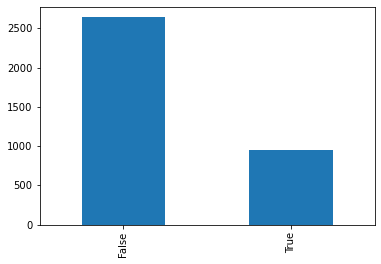

In [10]:
data['Churn'].value_counts().plot(kind='bar')

## копия датасета с нормировкой мин макс

In [5]:
data2 = data.copy()
data2['TotalCharges']/=np.max(data2['TotalCharges'])
data2['MonthlyCharges']/=np.max(data2['MonthlyCharges'])
data2['Tenure']/=np.max(data2['Tenure'])

In [62]:


data2.head(5)
# data.head(5)

,Gender,Senior,Married,Dependents,Tenure,Phone,MultiplePhones,Internet,Security,Backup,...,TV,Movies,Contract,EBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,pers,pers2
Index,,,,,,,,,,,,,,,,,,,,,
0,1,0,1,1,0.931,0,2,1,1,1,...,1,0,0,0,1,2.891e-06,7.174e-04,False,2.994,1.611
1,1,0,0,0,0.472,1,1,1,1,1,...,0,0,1,1,2,8.061e-07,1.554e-03,True,2.495,1.691
2,1,1,1,0,1.000,1,1,0,1,1,...,0,0,0,1,0,1.209e-07,1.167e-01,False,1.980,2.131
3,1,0,1,1,0.875,1,0,1,1,1,...,0,0,0,0,2,3.886e-06,7.580e-04,False,2.994,1.611
4,0,0,1,1,0.958,1,1,0,0,1,...,1,0,1,0,1,2.245e-07,3.279e-02,False,2.268,2.126


Counter({False: 2639, True: 952})


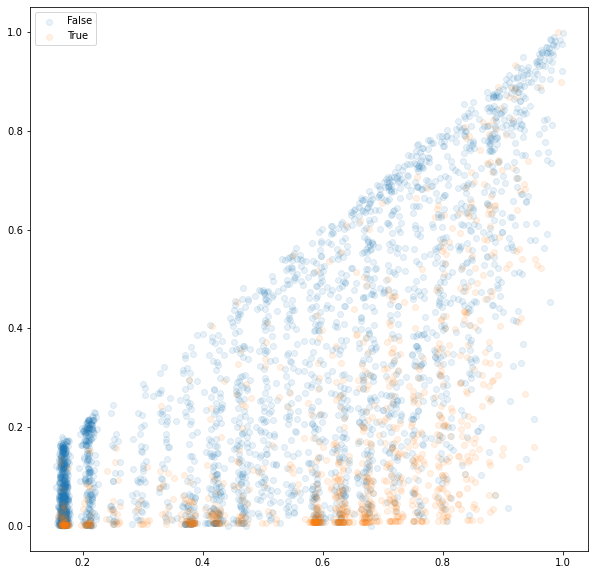

In [6]:
X,Y = data2.drop(['Churn','Phone','Gender','MultiplePhones'],axis=1).values,data2['Churn'].values
plt.figure(figsize=(10,10))
counter = Counter(Y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(Y == label)[0]
    plt.scatter(X[row_ix, 14], X[row_ix, 15], label=str(label), alpha=0.1)
plt.legend()
plt.show()

## думали аугментировать данные, норезультат не впечатлил, в последствии отказались

Counter({False: 2639, True: 952})


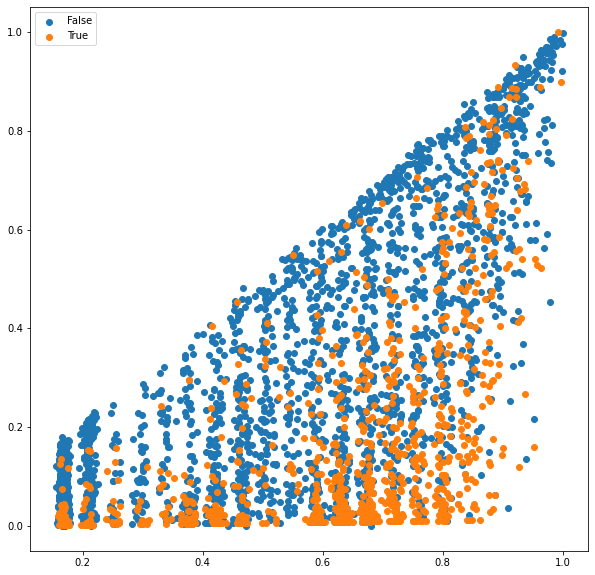

Counter({False: 893, True: 309})


In [7]:
X,Y = data2.drop(['Churn','Phone','Gender'],axis=1).values,data2['Churn'].values
plt.figure(figsize=(10,10))
counter = Counter(Y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(Y == label)[0]
    plt.scatter(X[row_ix, 15], X[row_ix, 16], label=str(label))
plt.legend()
plt.show()
X_train,X_test,Y_train,Y_test=train_test_split(X, Y, test_size=0.33, random_state=3)
X_train,X_val,Y_train,Y_val=train_test_split(X_train, Y_train, test_size=0.5, random_state=3)
counter = Counter(Y_train)
print(counter)

In [48]:
X_train


array([[0.   , 0.   , 0.   , ..., 3.   , 0.887, 0.063],
       [0.   , 1.   , 1.   , ..., 0.   , 0.771, 0.687],
       [1.   , 0.   , 0.   , ..., 3.   , 0.685, 0.027],
       ...,
       [0.   , 0.   , 0.   , ..., 2.   , 0.165, 0.143],
       [1.   , 1.   , 0.   , ..., 3.   , 0.844, 0.789],
       [1.   , 1.   , 0.   , ..., 3.   , 0.743, 0.479]])

In [49]:
Y_train

array([[0.   , 0.   , 0.   , ..., 2.   , 0.249, 0.034],
       [0.   , 1.   , 0.   , ..., 2.   , 0.634, 0.114],
       [0.   , 1.   , 0.   , ..., 1.   , 0.2  , 0.167],
       ...,
       [0.   , 0.   , 1.   , ..., 1.   , 0.468, 0.232],
       [0.   , 0.   , 0.   , ..., 2.   , 0.171, 0.024],
       [0.   , 0.   , 0.   , ..., 3.   , 0.805, 0.011]])

Counter({False: 893, True: 893})


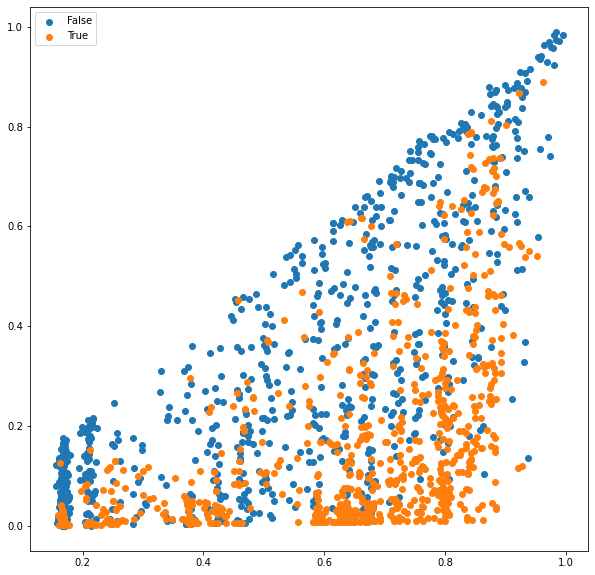

In [10]:
oversample = SMOTE()
X2, Y2 = oversample.fit_resample(X_train, Y_train)
counter2 = Counter(Y2)
print(counter2)
plt.figure(figsize=(10,10))
# scatter plot of examples by class label
for label, _ in counter2.items():
    row_ix = np.where(Y2 == label)[0]
    X2[row_ix,:14] = np.round(X2[row_ix,:14])
    plt.scatter(X2[row_ix, 15], X2[row_ix, 16], label=str(label))
plt.legend()
plt.show()
X_train = X2
Y_train = Y2

## корреляция без всяких добавок

<AxesSubplot:>

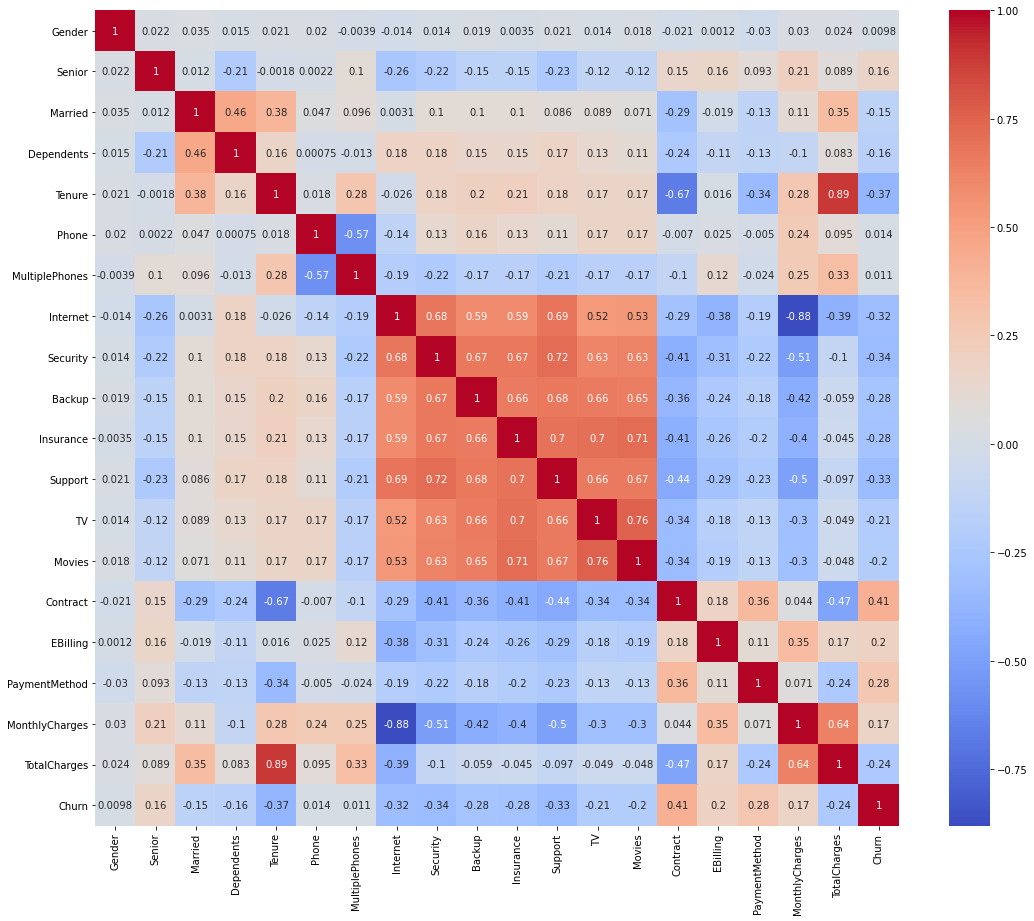

In [11]:
plt.figure(figsize=(18,15))
sns.heatmap(data[numeric_data.columns.tolist() + ['Churn']].corr(method = 'spearman'), cmap='coolwarm', annot = True)

<AxesSubplot:>

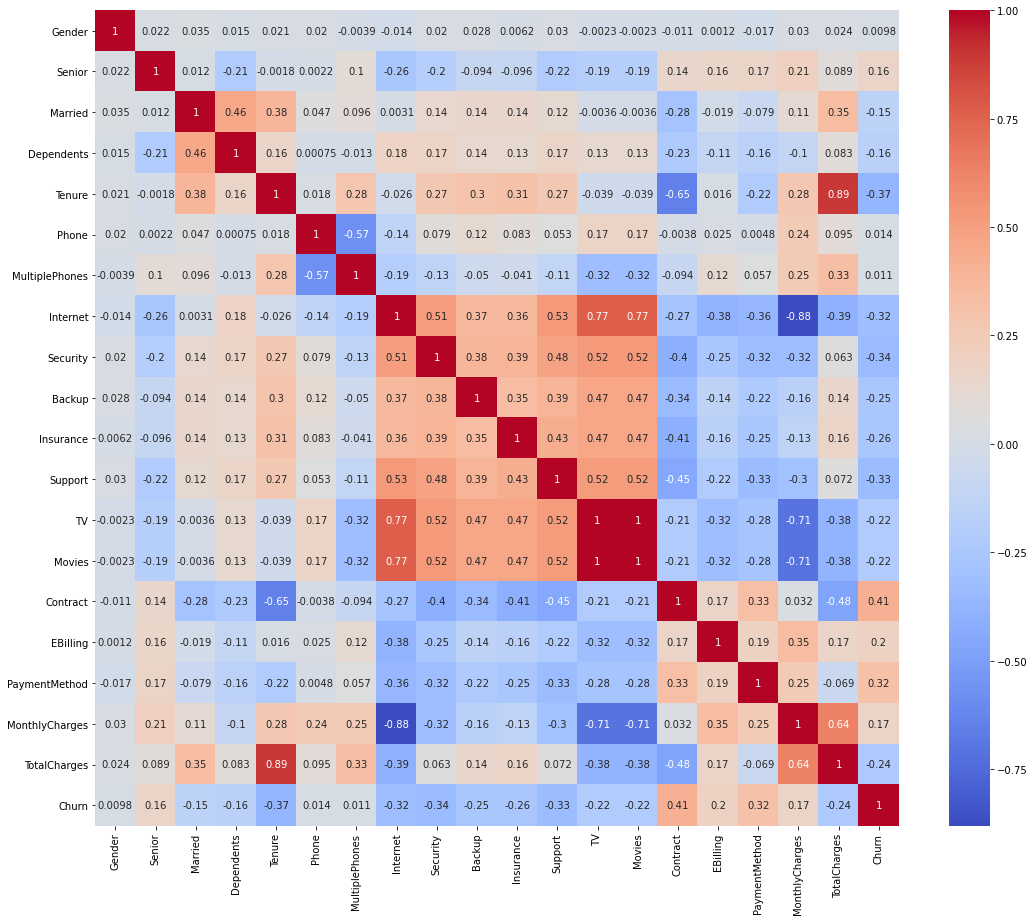

In [209]:
plt.figure(figsize=(18,15))
sns.heatmap(data2[numeric_data.columns.tolist() + ['Churn']].corr(method = 'spearman'), cmap='coolwarm', annot = True)

## как вариант xgboost классификатора

In [213]:
chip_i_deil= xg.XGBClassifier(objective ='binary:logistic', 
                                                      n_estimators = 50, 
                                                      reg_lambda = 0.0,
                                                      eta = 0.1,
                                                      max_depth = 9,
                                                      min_child_weight = 13,
                                                      scale_pos_weight = 1,
                                                      seed = 0)

In [214]:
chip_i_deil.fit(X2,Y2)

[13:23:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=9,
              min_child_weight=13, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=0.0, scale_pos_weight=1, seed=0,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [222]:
X_test.shape

(898, 16)

In [215]:
results = chip_i_deil.predict(X_test)
results2 = chip_i_deil.predict(X2)

In [138]:
print(Counter(results==Y_test)[1]/(Counter(results==Y_test)[1]+Counter(results==Y_test)[0]))

0.7873051224944321


In [216]:
matthews_corrcoef(Y_test,results)

0.46837514549576204

In [387]:
matthews_corrcoef(Y2,results2)

0.7169850498964092

## модель catboost 

0.4947761401280778
0.4964076029225172

In [37]:
features = [1,2,4,5,6,7,8,9,10,11,12,13,14]
cnt = Counter(Y_train)
scale = cnt[0] / cnt[1]
eval_set = [(X_val, Y_val)]
# eval_set = [(X_test, Y_test)]
chip_i_deil2= CatBoostClassifier(
                          n_estimators = 1500, 
                          colsample_bylevel=0.1,
    #                         max_leaves=31,
                        subsample=0.8,
                        verbose=0,
                        thread_count=-1,
                        leaf_estimation_iterations=1,
#                         leaf_estimation_method='Newton',
                        eval_metric='MCC',
                        
#                         bootstrap_type='MVS',
#                         grow_policy='Depthwise',
#                         cat_features=features,
#                         min_data_in_leaf=1,
                        max_depth=1,
                        scale_pos_weight=scale,
#                         boosting_type='Ordered',
#                         leaf_estimation_backtracking='Armijo',
                        random_state=1000,
    use_best_model=True,
learning_rate = 0.02)

#### без features 

In [30]:
features = [1,2,4,5,6,7,8,9,10,11,12,13,14]
# eval_set = [(X_val, Y_val)]
eval_set = [(X_test, Y_test)]
chip_i_deil2= CatBoostClassifier(
                          n_estimators = 1500, 
#                           colsample_bylevel=0.1,
#                         max_leaves=31,
                        subsample=0.8,
                        verbose=0,
                        thread_count=-1,
                        leaf_estimation_iterations=1,
#                         leaf_estimation_method='Newton',
                        eval_metric='MCC',
                        
#                         bootstrap_type='MVS',
#                         grow_policy='Depthwise',
                        cat_features=features,
#                         min_data_in_leaf=1,
#                         max_depth=10,
                        scale_pos_weight=scale,
#                         boosting_type='Ordered',
#                         leaf_estimation_backtracking='Armijo',
                        random_state=1000,
    use_best_model=True,
learning_rate = 0.005)

In [38]:
chip_i_deil2.fit(X_train,Y_train,eval_set = eval_set)

In [39]:
results = chip_i_deil2.predict(X_test)
results2 = chip_i_deil2.predict(X_train)

In [40]:
print(matthews_corrcoef(Y_test.astype(str),results))
print(matthews_corrcoef(Y_train.astype(str),results2))

0.43541660385517666
0.4667663034445742


# разбивка

In [16]:
X_train, Y_train = data.drop(['Churn','Phone','Gender'], axis=1), data.Churn

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=1000)

In [18]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=3)
cnt = Counter(Y_train)
scale = cnt[0] / cnt[1]

In [28]:
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


## герерация моделей для мажоритарки

In [54]:
X_train, Y_train = data.drop(['Churn','Phone','Gender'], axis=1), data.Churn
# clf = RandomForestClassifier(warm_start=True,n_estimators=500,max_depth=5)
# clf = DecisionTreeClassifier(max_depth=5)
# clf = GaussianNB()
# clf = LogisticRegression(penalty='l1',solver='liblinear')
# clf = RidgeClassifier()
clf =   SVC(gamma=1, C=0.025)
# clf =  GaussianProcessClassifier(1.0 * RBF(1.0))
# clf = MLPClassifier(alpha=0.025, max_iter=1000,early_stopping=True)
# clf =  AdaBoostClassifier(learning_rate=0.05,n_estimators=1000)
# clf = QuadraticDiscriminantAnalysis(reg_param=0.025)
clf=  KNeighborsClassifier(10)
for i in range(10):
    X_train, Y_train = data.drop(['Churn','Phone','Gender'], axis=1), data.Churn
    X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.05)
#     X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=i*10)
    cnt = Counter(Y_train)
    scale = cnt[0] / cnt[1]
    clf.fit(X_train,Y_train)
    results = clf.predict(X_test)
#     results2 = clf.predict(X_val)
    results3 = clf.predict(X_train)
    print("test" , str(matthews_corrcoef(Y_test,results)) , " "  , str(i))
    print('train' , str(matthews_corrcoef(Y_train,results3)) , ' ' , str(i))
#     print('val', str(matthews_corrcoef(Y_val,results2)) , ' ' , str(i))
    y_test_pred = clf.predict(X_traint)
    answer = pd.DataFrame(data=y_test_pred,
    columns=['Churn'])
    answer.index.name = 'Index'
    stri = './answer'  + 'KNR' +  str(i) + '.csv'
    answer.to_csv(stri)

test 0.3573232715252754   0
train 0.4475244322409094   0
test 0.22095984542032018   1
train 0.4400558745091435   1
test 0.386192035845982   2
train 0.4361953089691227   2
test 0.37234154758203314   3
train 0.4499183878911059   3
test 0.42947784519366666   4
train 0.4448951383251629   4
test 0.276512309013891   5
train 0.4471729529895762   5
test 0.28765698979653154   6
train 0.4415258910829391   6
test 0.2610181573713294   7
train 0.4497615954709003   7
test 0.41234383821456194   8
train 0.44639347464571993   8
test 0.35256508720803514   9
train 0.4341817236139624   9


In [23]:
cnt = Counter(Y_train)
scale = cnt[0] / cnt[1]

## пайплайны прошлые

In [14]:
# numeric_features = ['Gender', 'Senior', 'Married', 'Dependents', 'Tenure', 'Phone', 'EBilling', 'MonthlyCharges', 'TotalCharges']
numeric_features = [ 'TotalCharges','MultiplePhones',
                    'Contract', 'PaymentMethod','TV','Movies','Internet', 'Married','Insurance','TV','Movies','Security', 'Support','Backup','Contract','Insurance','Senior','Married','Dependents','Tenure', 
                    'EBilling','MonthlyCharges','Internet', 'Security', 'Support','Backup','MultiplePhones','TV', 'Movies']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = []
categorical_transformer = Pipeline(steps=[
    ('dummy', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

## тестирование через грид моделей

In [19]:
gridScorer = make_scorer(matthews_corrcoef)

clfgb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GridSearchCV(xg.XGBClassifier(objective ='binary:logistic', verbosity = 0, seed = 0), 
                                                  param_grid={'n_estimators': np.arange(40, 80, 10),
                                                             'max_depth' : np.arange(3, 10, 2),
                                                             'min_child_weight' : np.arange(7, 15, 3),
                                                             'eta' : [1e-2, 0.1, 0.2, 0.3],
                                                             'scale_pos_weight' : [scale],
                                                             'reg_lambda' : np.arange(0, .3, 0.15)},
                        scoring=gridScorer, cv=5, verbose=1, n_jobs=-1)) ])

# clfgb = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', GridSearchCV(xg.XGBClassifier(objective ='binary:logistic', verbosity = 0, seed = 0), 
#                                                   param_grid={'n_estimators': np.arange(40, 50, 10),
#                                                                      'max_depth' : np.arange(7, 8, 1),
#                                                              'min_child_weight' : np.arange(19, 21, 4),
#                                                              'eta' : [0.2],
#                                                              'scale_pos_weight' : [scale],
#                                                              'reg_lambda' : np.arange(0.2, .22, 0.15)},
#                         scoring=gridScorer, cv=5, verbose=1, n_jobs=-1)) ])

In [265]:
clfgb.fit(X_train, Y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Married', 'Dependents',
                                                   'Tenure', 'EBilling',
                                                   'MonthlyCharges',
                                                   'TotalCharges', 'Contract',
                                                   'PaymentMethod', 'Senior',
                                                   'Insurance']),
                                                 ('cat',
                                                  Pipeline(steps=[('dummy',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
   

In [266]:
clfgb.steps[1][1].best_score_

0.4733178824582834

0.48161601566740336 5 data </br>
0.48379881920605844 </br>
0.48749795907267635 </br>
0.488700664980278 </br>
0.4962253080681128 </br>

In [267]:
results = clfgb.predict(X_test)
# results2 = clfgb.predict(X2)
matthews_corrcoef(Y_test,results)

0.45106401213149705

0.5069156844960289

In [41]:
chip_i_deil3 = xg.XGBClassifier(objective ='binary:logistic', 
                                                      n_estimators = 1050, 
                                                      reg_alpha = 0.3,
                                                      eta = 0.02,
                                                      max_depth = 3,
                                                      min_child_weight = 50,
                                                      scale_pos_weight =scale,
                                                      gamma = 1,
                                                      subsample = 0.8,
                                                      colsample_bylevel = 0.1,
                                                      seed = 3,
                               early_stopping_rounds=10)

In [42]:
chip_i_deil3.fit(X_train, Y_train)

[15:35:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:35:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              eta=0.02, gamma=1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.0199999996,
              max_delta_step=0, max_depth=3, min_child_weight=50, missing=nan,
              monotone_constraints='()', n_estimators=1050, n_jobs=8,
              num_parallel_tree=1, random_state=3, reg_alpha=0.3, reg_lambda=1,
              scale_pos_weight=2.8899676375404533, seed=3, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
results = chip_i_deil3.predict(X_test)
# results2 = clfgb.predict(X2)
matthews_corrcoef(Y_test,results)


0.45792480585823103

In [ ]:
                                                      n_estimators = 5000, 
                                                      reg_alpha = 0.3,
                                                      eta = 0.003,
                                                      max_depth = 3,
                                                      min_child_weight = 50,
                                                      scale_pos_weight =scale,
                                                      gamma = 1,
                                                      subsample = 0.8,
                                                      colsample_bylevel = 0.1,
                                                      seed = 3,

MCC TEST: 46.81%
MCC TRAIN: 51.21%
MCC VALIDATION: 49.89%

## тестирование через графики 

[15:38:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


MCC TEST: 43.88%
MCC TRAIN: 50.16%
MCC VALIDATION: 47.42%
TEST
              precision    recall  f1-score   support

       False       0.87      0.74      0.80       841
        True       0.53      0.74      0.62       345

    accuracy                           0.74      1186
   macro avg       0.70      0.74      0.71      1186
weighted avg       0.77      0.74      0.75      1186

TRAIN
              precision    recall  f1-score   support

       False       0.92      0.75      0.83       893
        True       0.53      0.81      0.64       309

    accuracy                           0.

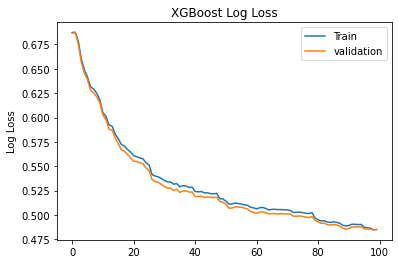

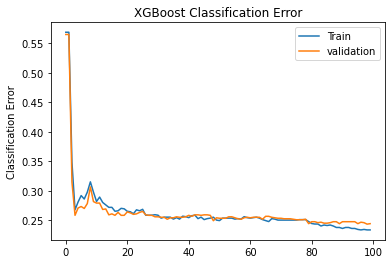

In [48]:
model = xg.XGBClassifier(objective ='binary:logistic', 
                                                       n_estimators = 100, 
                                                      reg_alpha = 0.3,
                                                      eta = 0.1,
                                                      max_depth = 5,
                                                      min_child_weight = 50,
                                                      scale_pos_weight =scale,
                                                      gamma = 1,
                                                      subsample = 0.8,
                                                      colsample_bylevel = 0.1,
                                                      seed = 3,
#                                                      booster='dart',
#                                                      rate_drop = 0.3,
#                                                      skip_drop = 0.2,
                               early_stopping_rounds=10)
eval_set = [(X_train, Y_train), (X_val, Y_val)]
# , (X_val, Y_val)
model.fit(X_train, Y_train, eval_metric=["error", "logloss"], 
          eval_set=eval_set, verbose=0)
# make predictions for test data
y_pred = model.predict(X_test)
y_predtrain = model.predict(X_train)
y_predval = model.predict(X_val)
predictions = y_pred
# [round(value) for value in y_pred]
# evaluate predictions
accuracy = matthews_corrcoef(Y_test, predictions)
print("MCC TEST: %.2f%%" % (accuracy * 100.0))
print("MCC TRAIN: %.2f%%" % (matthews_corrcoef(Y_train, y_predtrain) * 100.0))
print("MCC VALIDATION: %.2f%%" % (matthews_corrcoef(Y_val, y_predval) * 100.0))
from sklearn.metrics import classification_report, plot_confusion_matrix
print('TEST')
print (classification_report(Y_test, predictions))
print('TRAIN')
print (classification_report(Y_train, y_predtrain))
print('VALIDATION')
print (classification_report(Y_val, y_predval))

# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='validation')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='validation')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()



In [34]:
model = CatBoostClassifier(
                          n_estimators = 10000, 
                          colsample_bylevel=0.1,
                        max_leaves=31,
                        subsample=0.8,
                        verbose=2,
                        thread_count=-1,
                        leaf_estimation_iterations=2,
                        leaf_estimation_method='Newton',
                        eval_metric='MCC',
                        bootstrap_type='MVS',
                        max_depth=4,
                        scale_pos_weight=scale,
                        learning_rate = 0.002,
                        use_best_model=True,
                        penalties_coefficient=1,
                        random_state=10)
eval_set = [(X_val, Y_val)]
best = model.fit(X_train, Y_train, plot=True, 
          eval_set=eval_set, verbose=0,use_best_model=True)
# make predictions for test data
y_pred = model.predict(X_test)
y_predtrain = model.predict(X_train)
y_predval = model.predict(X_val)
predictions = y_pred
# [round(value) for value in y_pred]
# evaluate predictions

print("MCC TEST: %.2f%%" % (matthews_corrcoef(Y_test.astype(str), predictions) * 100.0))
print("MCC TRAIN: %.2f%%" % (matthews_corrcoef(Y_train.astype(str), y_predtrain) * 100.0))
print("MCC VALIDATION: %.2f%%" % (matthews_corrcoef(Y_val.astype(str), y_predval) * 100.0))
from sklearn.metrics import classification_report, plot_confusion_matrix
print('TEST')
print (classification_report(Y_test.astype(str), predictions))
print('TRAIN')
print (classification_report(Y_train.astype(str), y_predtrain))
print('VALIDATION')
print (classification_report(Y_val.astype(str), y_predval))
print("Count of trees in model = {}".format(model.tree_count_))
# retrieve performance metrics
# results = model.evals_result()
# epochs = len(results['validation_0']['error'])
# x_axis = range(0, epochs)
# # plot log loss
# fig, ax = plt.subplots()
# ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
# ax.plot(x_axis, results['validation_1']['logloss'], label='validation')
# ax.legend()
# plt.ylabel('Log Loss')
# plt.title('XGBoost Log Loss')
# plt.show()
# # plot classification error
# fig, ax = plt.subplots()
# ax.plot(x_axis, results['validation_0']['error'], label='Train')
# ax.plot(x_axis, results['validation_1']['error'], label='validation')
# ax.legend()
# plt.ylabel('Classification Error')
# plt.title('XGBoost Classification Error')
# plt.show()


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MCC TEST: 44.91%
MCC TRAIN: 52.21%
MCC VALIDATION: 47.32%
TEST
              precision    recall  f1-score   support

       False       0.90      0.72      0.80       792
        True       0.50      0.78      0.61       286

    accuracy                           0.74      1078
   macro avg       0.70      0.75      0.71      1078
weighted avg       0.79      0.74      0.75      1078

TRAIN
              precision    recall  f1-score   support

       False       0.94      0.73      0.82       937
        True       0.52      0.86      0.65       319

    accuracy                           0.76      1256
   macro avg       0.73      0.80      0.74      1256
weighted avg       0.83      0.76      0.78      1256

VALIDATION
              precision    recall  f1-score   support

       False       0.90      0.72      0.80       910
        True       0.52      0.80      0.63       347

    accuracy                           0.74      1257
   macro avg       0.71      0.76      0.72     

### Train with optimal parameters on full dataset

In [20]:
clf_best = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', xg.XGBClassifier(objective ='binary:logistic', 
                                                      n_estimators = 40, 
                                                      reg_lambda = 0.2,
                                                      eta = 0.1,
                                                      max_depth = 7,
                                                      min_child_weight = 19,
                                                      scale_pos_weight = scale,
                                                      seed = 0) )])
clf_best.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Gender', 'Senior',
                                                   'Married', 'Dependents',
                                                   'Tenure', 'Phone',
                                                   'EBilling', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('dummy',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['MultiplePhones', 'Internet',
                                                   'Se

<AxesSubplot:xlabel='TotalCharges'>

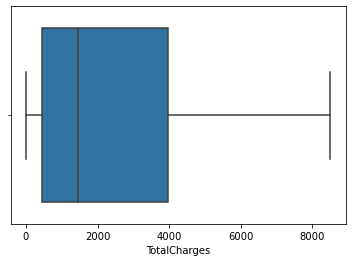

In [7]:
 sns.boxplot(data_test['TotalCharges'])

In [38]:
data_test = pd.read_csv('test.csv', index_col=0)
data_test.TotalCharges = data_test.TotalCharges.replace(' ', 0).astype(float)

### Save answers to csv

In [6]:
data_test = pd.read_csv('test.csv', index_col=0)
data_test = data_test.replace({'Gender': {'Female': 1, 'Male': 0}, 
                     'Married': {'Yes': 1, 'No': 0}, 
                     'Phone': {'Yes': 1, 'No': 0},
                     'Dependents': {'Yes': 1, 'No': 0},
                     'EBilling': {'Yes': 1, 'No': 0},
                     'MultiplePhones': {'Yes': 1, 'No': 0, 'No phone service':2},
                     'Internet' : {'DSL':1, 'Fiber optic':0,'No':2},
                     'Security' : {'Yes': 1, 'No': 0,'No internet service':2},
                     'Backup': {'Yes': 1, 'No': 0,'No internet service':2},
                     'Insurance' : {'Yes': 1, 'No': 0,'No internet service':2},
                     'Support' : {'Yes': 1, 'No': 0,'No internet service':2},
                     'TV' : {'Yes': 1, 'No': 0,'No internet service':2},
                     'Movies' : {'Yes': 1, 'No': 0,'No internet service':2},
                     'Contract' : {'Month-to-month': 2, 'One year': 1,'Two year':0},
                     'PaymentMethod' : {'Electronic check': 3, 'Mailed check': 2,'Bank transfer (automatic)':0,'Credit card (automatic)':1}
                    })
# data_test = data_test.replace({'Gender': {'Female': 1, 'Male': 0}, 
#                      'Married': {'Yes': 1, 'No': 0}, 
#                      'Phone': {'Yes': 1, 'No': 0},
#                      'Dependents': {'Yes': 1, 'No': 0},
#                      'EBilling': {'Yes': 1, 'No': 0},
#                      'MultiplePhones': {'Yes': 1, 'No': 0, 'No phone service':2},
#                      'Internet' : {'DSL':1, 'Fiber optic':0,'No':2},
#                      'Security' : {'Yes': 1, 'No': 0,'No internet service':1},
#                      'Backup': {'Yes': 1, 'No': 0,'No internet service':1},
#                      'Insurance' : {'Yes': 1, 'No': 0,'No internet service':1},
#                      'Support' : {'Yes': 1, 'No': 0,'No internet service':1},
#                      'TV' : {'Yes': 0, 'No': 0,'No internet service':2},
#                      'Movies' : {'Yes': 0, 'No': 0,'No internet service':2},
#                      'Contract' : {'Month-to-month': 2, 'One year': 0,'Two year':0},
#                      'PaymentMethod' : {'Electronic check': 3, 'Mailed check': 0,'Bank transfer (automatic)':0,'Credit card (automatic)':0}
#                     })
data_test.TotalCharges = data_test.TotalCharges.replace(' ', 0).astype(float)
# data_test.drop(['Phone','Gender','MultiplePhones'], axis=1,inplace=True)


In [67]:
data_test['pers'] = 0
data_test['pers']=data_test['pers'].astype(float)
ds = data_test.values
print(ds.shape)
for i in range(ds.shape[0]):
    sum = 0
    if data_test['Internet'][i]==2:
        sum+=0.1
    else:
        sum-=0.1
    if data_test['Security'][i]==2:
        sum+=0.05
    else:
        sum-=0.1
    if data_test['Backup'][i]==2:
        sum+=0.05
    else:
        sum-=0.1
    if data_test['TV'][i]==2:
        sum+=0.05
    else:
        sum-=0.1
    if data_test['Movies'][i]==2:
        sum+=0.05
    else:
        sum-=0.1
    if data_test['Insurance'][i]==2:
        sum+=0.05
    else:
        sum-=0.1
    if data_test['EBilling'][i]==0:
        sum+=0.025
    else:
        sum-=0.1
    if data_test['Support'][i]==1:
        sum+=0.1
    else:
        sum-=0.1
    if data_test['Senior'][i]==0:
        sum+=0.025
    if data_test['Contract'][i]==1 or data_test['Contract'][i]==0:
        sum+=0.3
    data_test['pers'][i] = -sum

(2395, 20)


In [7]:
X_traint = data_test.drop(['Phone','Gender'], axis=1)

In [182]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.5, random_state=10)

In [71]:
data_test['TotalCharges']/=np.max(data_test['TotalCharges'])
data_test['MonthlyCharges']/=np.max(data_test['MonthlyCharges'])
data_test['Tenure']/=np.max(data_test['Tenure'])

In [194]:
data_test.values.shape

(2395, 16)

In [30]:
y_test_pred = chip_i_deil2.predict(X_traint)
answer = pd.DataFrame(data=y_test_pred,
                      columns=['Churn'])
answer.index.name = 'Index'

In [31]:
answer.to_csv('./answer12.csv')

In [3]:
# import tensorflow as tf
# import tensorflow.compat.v1 as tfv1
import tqdm

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
import keras as ks
# from tensorflow.python.framework import ops
import cv2 as cv
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,BatchNormalization

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import matthews_corrcoef, make_scorer, matthews_corrcoef
from sklearn.linear_model import LogisticRegression

In [ ]:
from keras.metrics import 

In [4]:
data = pd.read_csv('train.csv', index_col=0)
data.head(5)

,Gender,Senior,Married,Dependents,Tenure,Phone,MultiplePhones,Internet,Security,Backup,Insurance,Support,TV,Movies,Contract,EBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
Index,,,,,,,,,,,,,,,,,,,,
0,Female,0,Yes,Yes,67,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),54.20,3623.95,False
1,Female,0,No,No,34,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,One year,Yes,Mailed check,64.40,2088.75,True
2,Female,1,Yes,No,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,No,No,Two year,Yes,Bank transfer (automatic),96.60,6827.5,False
3,Female,0,Yes,Yes,63,Yes,No,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,Mailed check,63.55,4014.2,False
4,Male,0,Yes,Yes,69,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,No,One year,No,Credit card (automatic),95.75,6511.25,False


In [5]:
data.TotalCharges = data.TotalCharges.replace(' ', 0).astype(float)
data = data.replace({'Gender': {'Female': 1, 'Male': 0}, 
                     'Married': {'Yes': 1, 'No': 0}, 
                     'Phone': {'Yes': 1, 'No': 0},
                     'Dependents': {'Yes': 1, 'No': 0},
                     'EBilling': {'Yes': 1, 'No': 0},
                     'MultiplePhones': {'Yes': 1, 'No': 0, 'No phone service':2},
                     'Internet' : {'DSL':1, 'Fiber optic':0,'No':2},
                     'Security' : {'Yes': 1, 'No': 0,'No internet service':2},
                     'Backup': {'Yes': 1, 'No': 0,'No internet service':2},
                     'Insurance' : {'Yes': 1, 'No': 0,'No internet service':2},
                     'Support' : {'Yes': 1, 'No': 0,'No internet service':2},
                     'TV' : {'Yes': 1, 'No': 0,'No internet service':2},
                     'Movies' : {'Yes': 1, 'No': 0,'No internet service':2},
                     'Contract' : {'Month-to-month': 2, 'One year': 1,'Two year':0},
                     'PaymentMethod' : {'Electronic check': 3, 'Mailed check': 2,'Bank transfer (automatic)':0,'Credit card (automatic)':1}
                    })
numeric_data = data.select_dtypes(include=np.number)
numeric_data.head(4)

,Gender,Senior,Married,Dependents,Tenure,Phone,MultiplePhones,Internet,Security,Backup,Insurance,Support,TV,Movies,Contract,EBilling,PaymentMethod,MonthlyCharges,TotalCharges
Index,,,,,,,,,,,,,,,,,,,
0,1,0,1,1,67,0,2,1,1,1,1,1,1,0,0,0,1,54.20,3623.95
1,1,0,0,0,34,1,1,1,1,1,0,1,0,0,1,1,2,64.40,2088.75
2,1,1,1,0,72,1,1,0,1,1,1,1,0,0,0,1,0,96.60,6827.50
3,1,0,1,1,63,1,0,1,1,1,1,1,0,0,0,0,2,63.55,4014.20


In [6]:
std_scaler = StandardScaler().fit(data.drop(['Churn','Phone','Gender','MultiplePhones'], axis=1))
cols_std_scaled = std_scaler.transform(data.drop(['Churn','Phone','Gender','MultiplePhones'], axis=1))

In [6]:
data['TotalCharges']/=np.max(data['TotalCharges'])
data['MonthlyCharges']/=np.max(data['MonthlyCharges'])

In [6]:
data

,Gender,Senior,Married,Dependents,Tenure,Phone,MultiplePhones,Internet,Security,Backup,Insurance,Support,TV,Movies,Contract,EBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
Index,,,,,,,,,,,,,,,,,,,,
0,1,0,1,1,67,0,2,1,1,1,1,1,1,0,0,0,1,0.456421,0.417275,False
1,1,0,0,0,34,1,1,1,1,1,0,1,0,0,1,1,2,0.542316,0.240506,True
2,1,1,1,0,72,1,1,0,1,1,1,1,0,0,0,1,0,0.813474,0.786144,False
3,1,0,1,1,63,1,0,1,1,1,1,1,0,0,0,0,2,0.535158,0.462210,False
4,0,0,1,1,69,1,1,0,0,1,1,0,1,0,1,0,1,0.806316,0.749729,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3586,1,0,0,0,5,1,0,0,0,0,0,0,1,0,2,0,3,0.675368,0.044244,False
3587,1,0,1,1,71,1,0,1,1,0,1,0,1,1,0,0,1,0.653053,0.641851,False
3588,1,0,1,0,68,1,1,0,0,1,1,0,0,0,1,0,1,0.728000,0.663567,False


In [7]:
x_train, y_train = data.drop(['Churn','Phone','Gender','MultiplePhones'],axis=1).values, data['Churn'].values

In [8]:
y_train

array([False,  True, False, ..., False, False, False])

## тестировали mlp

In [37]:
num_train = x_train.shape[0]
# num_test = 10000 

num_classes = 2 

batch_size = 128
num_epochs = 20 
hidden_size = 512

# X_train = train_data.reshape(num_train, height * width) 
# X_test = eval_data.reshape(num_test, height * width) 
# X_train = X_train.astype('float32') 
# X_test = X_test.astype('float32')


y_train_n = np_utils.to_categorical(y_train, num_classes) # One-hot encode the labels

modelmlp = Sequential()
modelmlp.add(Dense(hidden_size, activation='relu'))
modelmlp.add(Dense(hidden_size, activation='relu'))
modelmlp.add(Dense(hidden_size, activation='relu'))
modelmlp.add(BatchNormalization())
modelmlp.add(Dense(num_classes, activation='softmax'))
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
modelmlp.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics='accuracy'
             ) 

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50)
mc = ModelCheckpoint('letters_best2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

modelmlp.fit(x_train, y_train_n, 
          batch_size=batch_size, epochs=num_epochs,
          verbose=1, validation_split=0.05,
            use_multiprocessing = True,
            callbacks=[learning_rate_reduction, es, mc])

Epoch 1/20
22/27 [=======================>......] - ETA: 0s - loss: 0.5955 - accuracy: 0.7493
Epoch 00001: val_accuracy improved from -inf to 0.81667, saving model to letters_best2.h5
27/27 [==============================] - 0s 13ms/step - loss: 0.5696 - accuracy: 0.7552 - val_loss: 0.3889 - val_accuracy: 0.8167
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 0.4234 - accuracy: 0.8004
Epoch 00002: val_accuracy did not improve from 0.81667
27/27 [==============================] - 0s 8ms/step - loss: 0.4234 - accuracy: 0.8004 - val_loss: 0.5133 - val_accuracy: 0.7111
Epoch 3/20
21/27 [======================>.......] - ETA: 0s - loss: 0.4272 - accuracy: 0.7924
Epoch 00003: val_accuracy did not improve from 0.81667
27/27 [==============================] - 0s 8ms/step - loss: 0.4223 - accuracy: 0.7962 - val_loss: 0.3827 - val_accuracy: 0.8000
Epoch 4/20
21/27 [======================>.......] - ETA: 0s - loss: 0.4210 - accuracy: 0.7909
Epoch 00004: ReduceLROnPlateau reduc

In [38]:
mdl = load_model('letters_best2.h5')


In [40]:
y_val = mdl.predict(x_train)

In [39]:
np.argmax(y_val,axis=1)

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [17]:
y_train

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [41]:
matthews_corrcoef(y_train,np.argmax(y_val,axis=1))

0.4865187438560393